# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

## Подготовка данных

In [1]:
#Подключаем библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from numpy.random import RandomState
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.dummy import DummyRegressor

In [2]:
# Загрузим датасеты 
train_df = pd.read_csv('/datasets/gold_recovery_train_new.csv')
test_df = pd.read_csv('/datasets/gold_recovery_test_new.csv')
full_df = pd.read_csv('/datasets/gold_recovery_full_new.csv')

In [3]:
# Создаем функцию вывода информации по всем датафрейдам
def fun_date(data):
    print('**Общая информация датафрейма**')
    print(data.info())
    print('-------------------------------------------------------------------------------------------------------------')
    print('**Вывод первых пяти строк датафрейма**')
    print(data.head(5))
    print('-------------------------------------------------------------------------------------------------------------')
    print('**Вывод количесва дубликатов датафрейма**')
    print(data.duplicated().sum())
    print('-------------------------------------------------------------------------------------------------------------')
    print('**Вывод количесва пропущеных значений датафрейма**')
    print(data.isnull().sum())
    print('-------------------------------------------------------------------------------------------------------------')
print('ОБУЧАЮЩАЯ ВЫБОРКА------------------------------------------------------------------------------------------------')
print(fun_date(train_df))
print('ТЕСТОВАЯ ВЫБОРКА-------------------------------------------------------------------------------------------------')
print(fun_date(test_df))
print('ПОЛНАЯ ВЫБОРКА---------------------------------------------------------------------------------------------------')
print(fun_date(full_df))

ОБУЧАЮЩАЯ ВЫБОРКА------------------------------------------------------------------------------------------------
**Общая информация датафрейма**
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.outpu

После ознакомления с данными стало известно что: 
    
1. В данных есть пропуски
2. Нужно изменить тип данных в колонке date.

In [4]:
# Изменим тип данных колонки date на datetime
train_df['date'] = pd.to_datetime(train_df['date'], format='%Y-%m-%d %H:%M:%S')
train_df.dtypes

date                                          datetime64[ns]
final.output.concentrate_ag                          float64
final.output.concentrate_pb                          float64
final.output.concentrate_sol                         float64
final.output.concentrate_au                          float64
                                                   ...      
secondary_cleaner.state.floatbank5_a_level           float64
secondary_cleaner.state.floatbank5_b_air             float64
secondary_cleaner.state.floatbank5_b_level           float64
secondary_cleaner.state.floatbank6_a_air             float64
secondary_cleaner.state.floatbank6_a_level           float64
Length: 87, dtype: object

In [5]:
test_df['date'] = pd.to_datetime(test_df['date'], format='%Y-%m-%d %H:%M:%S')
test_df.dtypes

date                                          datetime64[ns]
primary_cleaner.input.sulfate                        float64
primary_cleaner.input.depressant                     float64
primary_cleaner.input.feed_size                      float64
primary_cleaner.input.xanthate                       float64
primary_cleaner.state.floatbank8_a_air               float64
primary_cleaner.state.floatbank8_a_level             float64
primary_cleaner.state.floatbank8_b_air               float64
primary_cleaner.state.floatbank8_b_level             float64
primary_cleaner.state.floatbank8_c_air               float64
primary_cleaner.state.floatbank8_c_level             float64
primary_cleaner.state.floatbank8_d_air               float64
primary_cleaner.state.floatbank8_d_level             float64
rougher.input.feed_ag                                float64
rougher.input.feed_pb                                float64
rougher.input.feed_rate                              float64
rougher.input.feed_size 

In [6]:
full_df['date'] = pd.to_datetime(full_df['date'], format='%Y-%m-%d %H:%M:%S')
full_df.dtypes

date                                          datetime64[ns]
final.output.concentrate_ag                          float64
final.output.concentrate_pb                          float64
final.output.concentrate_sol                         float64
final.output.concentrate_au                          float64
                                                   ...      
secondary_cleaner.state.floatbank5_a_level           float64
secondary_cleaner.state.floatbank5_b_air             float64
secondary_cleaner.state.floatbank5_b_level           float64
secondary_cleaner.state.floatbank6_a_air             float64
secondary_cleaner.state.floatbank6_a_level           float64
Length: 87, dtype: object

In [7]:
# Проверка на явные дубликаты
cnt = 0
for df in [train_df, test_df, full_df]:
    cnt += 1
    print(f'\nЯвных дубликатов в {cnt}-ом датасете - ',df.duplicated().sum())


Явных дубликатов в 1-ом датасете -  0

Явных дубликатов в 2-ом датасете -  0

Явных дубликатов в 3-ом датасете -  0


In [8]:
# С помощью функции ffill заполним отсутствующие значения в тренировочной и тестовой выборках. 
size_of_train_df_before = train_df.shape
size_of_test_df_before = test_df.shape
size_of_full_df_before = full_df.shape
train_df = train_df.ffill(axis=0)
test_df = test_df.ffill(axis=0)
full_df = full_df.ffill(axis=0)
print(f'\nРазмер тренировочной выборки - {size_of_train_df_before} и количество строк без пропусков - {len(train_df.notna())}')
print(f'\nРазмер тестовой выборки - {size_of_test_df_before} и количество строк без пропусков - {len(test_df.notna())}')
print(f'\nРазмер исходной выборки - {size_of_full_df_before} и количество строк без пропусков - {len(full_df.notna())}')


Размер тренировочной выборки - (14149, 87) и количество строк без пропусков - 14149

Размер тестовой выборки - (5290, 53) и количество строк без пропусков - 5290

Размер исходной выборки - (19439, 87) и количество строк без пропусков - 19439


Пропуски отсутствуют

Проверим формулу эффективности обогащения.

recovery = ((C(F-T))/(FC-T))*100%, где:

С - доля золота концентрате после фильтрации/очитски

F - доля золота в сырье/концентрате до флотации/очистки

T - доля золота в отвальных хвостах после фильтрации/очистки

In [9]:
c = train_df['rougher.output.concentrate_au']
f = train_df['rougher.input.feed_au']
t = train_df['rougher.output.tail_au']
recovery = ((c*(f-t))/(f*(c-t))) * 100
print('MAE -', mean_absolute_error(train_df['rougher.output.recovery'], recovery))

MAE - 9.73512347450521e-15


Полученное значение МАЕ маленькое, значит расчеты верны.

In [10]:
# Анализ признаков недоступных в тестовой выборке
missed_signs = set(train_df.columns) - set(test_df.columns)
missed_signs

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

In [11]:
dict_with_name_of_values = {'final': 'финальные характеристики',
                           'primary_cleaner': 'первичная очистка',
                           'secondary_cleaner': 'вторичная очистка',
                           'input': 'параметры сырья',
                           'output': 'параметры продукта',
                           'rougher': 'флотация',
                           'state': 'параметры, характеризующие текущее состояние этапа',
                           'calculation': 'расчётные характеристики'}

dict_for_missed_signs = {}
for sign in missed_signs:
    list_with_words = sign.split('.')
    stage = list_with_words[0]+'-'+list_with_words[1]
    if stage in dict_for_missed_signs:
        dict_for_missed_signs[stage].append(list_with_words[2])
    elif stage not in dict_for_missed_signs:
        dict_for_missed_signs[stage] = [list_with_words[2]]
        
for key in dict_for_missed_signs.keys():
    split_key = key.split('-')
    print('='*90)
    print(f'ДЛЯ ЭТАПА "{(dict_with_name_of_values[split_key[0]]).upper()}" С ОПЦИЕЙ "{(dict_with_name_of_values[split_key[1]]).upper()}" ОТСУТСТВУЮТ ЗНАЧЕНИЯ:')
    print('='*90)
    for elem in dict_for_missed_signs[key]:
        print(f' - {elem}')

ДЛЯ ЭТАПА "ФИНАЛЬНЫЕ ХАРАКТЕРИСТИКИ" С ОПЦИЕЙ "ПАРАМЕТРЫ ПРОДУКТА" ОТСУТСТВУЮТ ЗНАЧЕНИЯ:
 - concentrate_sol
 - recovery
 - concentrate_pb
 - tail_ag
 - concentrate_ag
 - tail_pb
 - tail_au
 - concentrate_au
 - tail_sol
ДЛЯ ЭТАПА "ПЕРВИЧНАЯ ОЧИСТКА" С ОПЦИЕЙ "ПАРАМЕТРЫ ПРОДУКТА" ОТСУТСТВУЮТ ЗНАЧЕНИЯ:
 - concentrate_sol
 - concentrate_pb
 - tail_sol
 - concentrate_ag
 - concentrate_au
 - tail_au
 - tail_ag
 - tail_pb
ДЛЯ ЭТАПА "ФЛОТАЦИЯ" С ОПЦИЕЙ "РАСЧЁТНЫЕ ХАРАКТЕРИСТИКИ" ОТСУТСТВУЮТ ЗНАЧЕНИЯ:
 - sulfate_to_au_concentrate
 - au_pb_ratio
 - floatbank10_sulfate_to_au_feed
 - floatbank11_sulfate_to_au_feed
ДЛЯ ЭТАПА "ФЛОТАЦИЯ" С ОПЦИЕЙ "ПАРАМЕТРЫ ПРОДУКТА" ОТСУТСТВУЮТ ЗНАЧЕНИЯ:
 - concentrate_pb
 - tail_au
 - concentrate_sol
 - recovery
 - concentrate_ag
 - tail_sol
 - tail_pb
 - tail_ag
 - concentrate_au
ДЛЯ ЭТАПА "ВТОРИЧНАЯ ОЧИСТКА" С ОПЦИЕЙ "ПАРАМЕТРЫ ПРОДУКТА" ОТСУТСТВУЮТ ЗНАЧЕНИЯ:
 - tail_ag
 - tail_au
 - tail_pb
 - tail_sol


В тестовой выборки отсутствуют целевые признаки rougher.output.recovery и final.output.recovery, которые будут нужны для расчета метрики качества. Добавим их в тестовую выборку, используя метод merge, в качестве индексов используем колонку date (данные индексируются датой и временем получения информации)

In [12]:
test_df = test_df.merge(full_df.loc[:, ['date','rougher.output.recovery','final.output.recovery']], on='date')

In [13]:
# Удаляем колонку date, так как она не влияет на обучение
train_df = train_df.drop('date', axis=1)
test_df = test_df.drop('date', axis=1)

In [14]:
print('\nРазмер тестовой выборки - {} | Размер тренировочной выборки - {}'.format(test_df.shape, train_df.shape))


Размер тестовой выборки - (5290, 54) | Размер тренировочной выборки - (14149, 86)


ВЫВОД:

Был изменен тип данных в колонки date. Пропуски в датасетах были заполнены значениями предшествующих по времени. Проведен расчет эффективности обогощения. МАЕ равно предельно малому значению, значит отличие предельно малое. в тестовую выборку были добавленны целевые признаки, которые будут необходимы в дальнейшем для расчета метрики качества. Была удаленна колонка date, так как она мешает обучению модели.

## Анализ данных

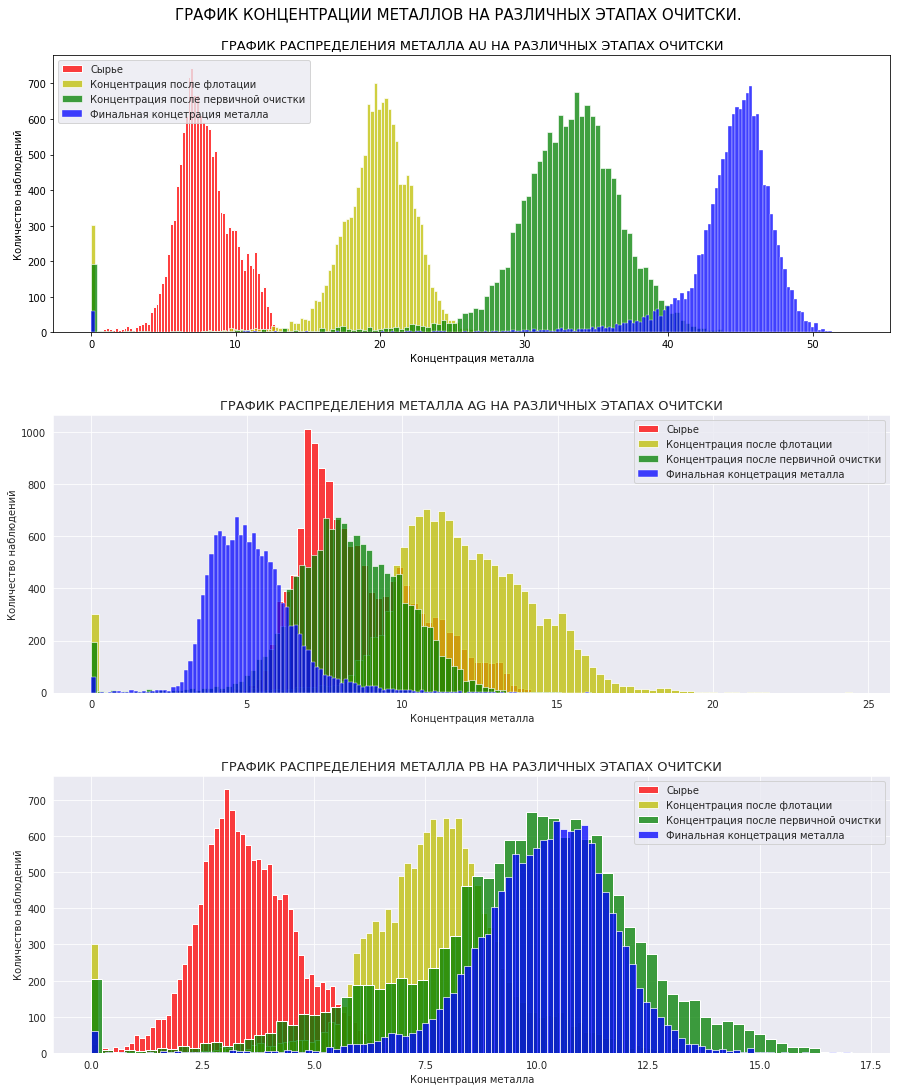

In [15]:
# Строим гистограммы концентрации металлов на различных этапах очистки.
position = 0
plt.figure(figsize=[15, 17])
plt.subplots_adjust(top=0.94, wspace=0.2, hspace=0.3)
plt.suptitle('ГРАФИК КОНЦЕНТРАЦИИ МЕТАЛЛОВ НА РАЗЛИЧНЫХ ЭТАПАХ ОЧИТСКИ.', fontsize=15)
for metal in ['au', 'ag', 'pb']:
    position += 1
    plt.subplot(3, 1, position)
    plt.title(f'ГРАФИК РАСПРЕДЕЛЕНИЯ МЕТАЛЛА {str(metal).upper()} НА РАЗЛИЧНЫХ ЭТАПАХ ОЧИТСКИ', fontsize=13)
    sns.set_style('darkgrid')
    sns.histplot(train_df[f'rougher.input.feed_{metal}'], color='r', label='Сырье', kde=False)
    sns.histplot(train_df[f'rougher.output.concentrate_{metal}'], color='y', label='Концентрация после флотации', kde=False)
    sns.histplot(train_df[f'primary_cleaner.output.concentrate_{metal}'], color='g', label='Концентрация после первичной очистки', kde=False)
    sns.histplot(train_df[f'final.output.concentrate_{metal}'], color='b', label='Финальная концетрация металла',kde=False)
    plt.xlabel('Концентрация металла')
    plt.ylabel('Количество наблюдений')
    plt.legend()
plt.show();

Концентрация металла AU(золото) после каждого этапа очистки увеличивается. Концентрация металла AG(серебро) увеличивается на этапе флотации, затем уменьшается. Концентрация металла PB(свинец) увеличивается на этапе флотации и после первичной очистки, после остается на прежнем уровне.

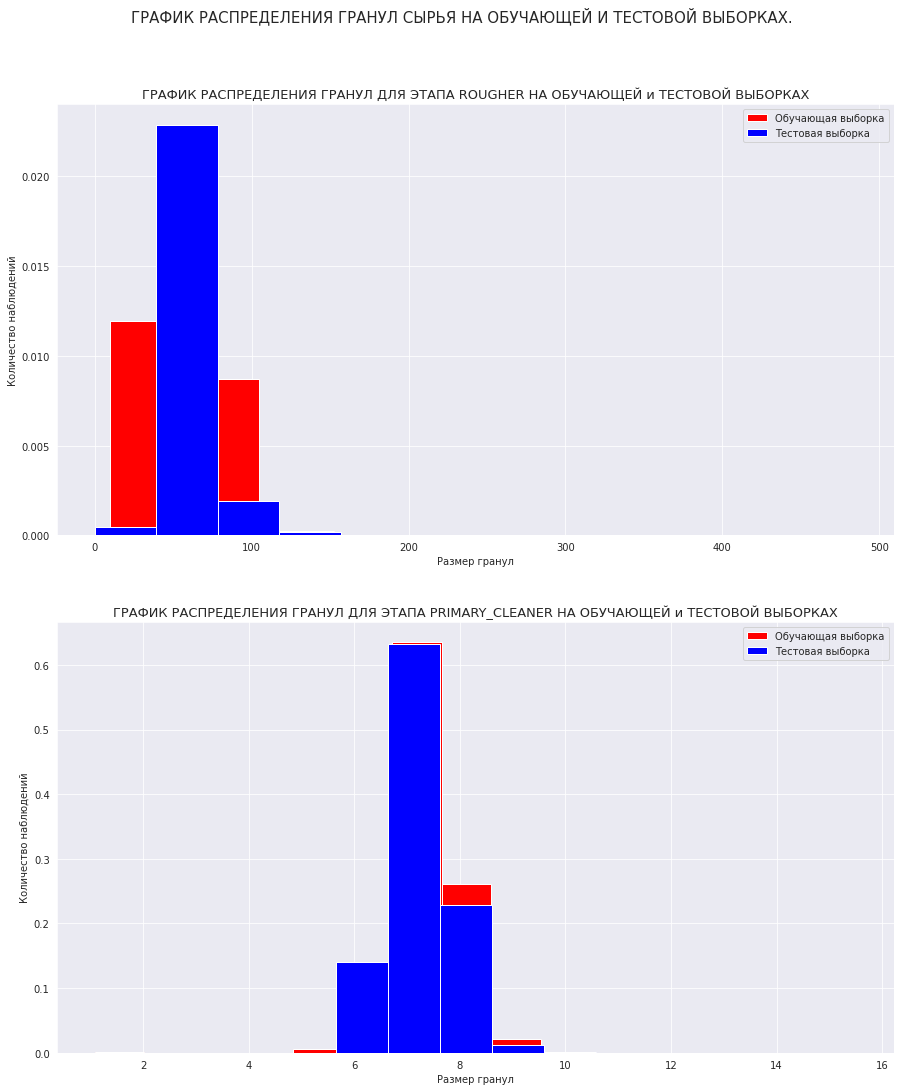

In [16]:
# Строим гистограмму распределения размеров гранул сырья на обучающей и тестовой выборках.
position = 0
plt.figure(figsize=[15, 17])
plt.subplots_adjust(top=0.90, wspace=0.2, hspace=0.2)
plt.suptitle('ГРАФИК РАСПРЕДЕЛЕНИЯ ГРАНУЛ СЫРЬЯ НА ОБУЧАЮЩЕЙ И ТЕСТОВОЙ ВЫБОРКАХ.', fontsize=15)
for stage in ['rougher', 'primary_cleaner']:
    position += 1
    plt.subplot(2, 1, position)
    plt.title(f'ГРАФИК РАСПРЕДЕЛЕНИЯ ГРАНУЛ ДЛЯ ЭТАПА {str(stage).upper()} НА ОБУЧАЮЩЕЙ и ТЕСТОВОЙ ВЫБОРКАХ', fontsize=13)
    sns.set_style('darkgrid')
    plt.hist(train_df[f'{stage}.input.feed_size'], color='r', label='Обучающая выборка', density=True)
    plt.hist(test_df[f'{stage}.input.feed_size'], color='b', label='Тестовая выборка', density=True)
    plt.xlabel('Размер гранул')
    plt.ylabel('Количество наблюдений')
    plt.legend()
plt.show();

Для этапа флотации распределение гранул находится примерно в одинаковом диапазоне, но для тренировочной выборки преобладают гранулы с размером ~ 50 , а для тестовой наоборот, ниже порога 50. Для этапа первичной очитски разспределение гранул для выборок находится в одном диапазоне, однако есть различия в количестве наблюдений. Так для тренировочной выборки количество наблюдений размера гранул больше, чем для тестовой. Таким образом, значимых различий между распределениями для выборок не наблюдается.

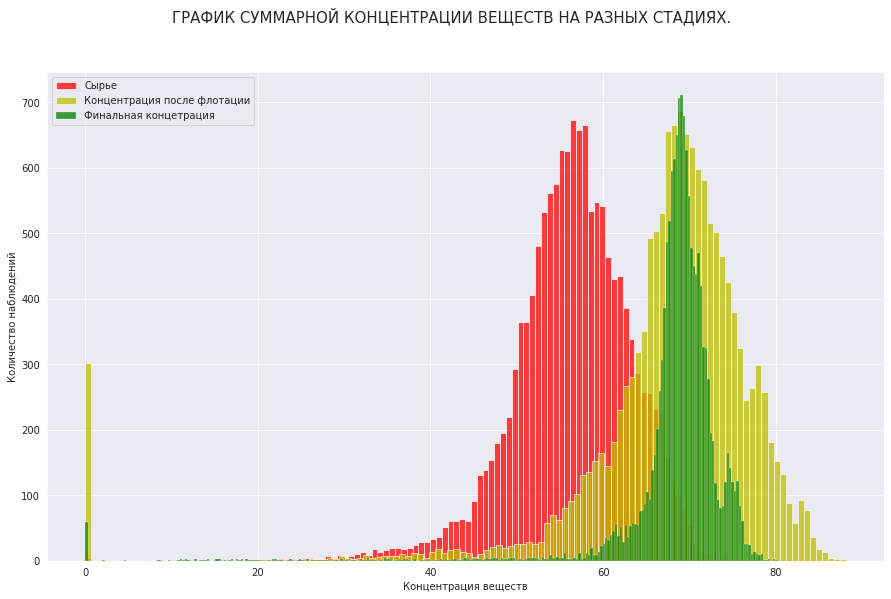

In [17]:
sum_concentrate_of_rougher_input = 0
sum_concentrate_of_rougher_output = 0
sum_concentrate_of_primary_cleaner_output = 0
sum_concentrate_of_final_output = 0
for metal in ['au', 'ag', 'pb', 'sol']:
    sum_concentrate_of_rougher_input += train_df[f'rougher.input.feed_{metal}']
    sum_concentrate_of_rougher_output += train_df[f'rougher.output.concentrate_{metal}']
#     sum_concentrate_of_primary_cleaner_output += full_df[f'primary_cleaner.output.concentrate_{metal}']
    sum_concentrate_of_final_output += train_df[f'final.output.concentrate_{metal}']

plt.figure(figsize=[15, 9])
plt.suptitle('ГРАФИК СУММАРНОЙ КОНЦЕНТРАЦИИ ВЕЩЕСТВ НА РАЗНЫХ СТАДИЯХ.', fontsize=15)
sns.set_style('darkgrid')
sns.histplot(sum_concentrate_of_rougher_input, color='r', label='Сырье', kde=False)
sns.histplot(sum_concentrate_of_rougher_output, color='y', label='Концентрация после флотации', kde=False)
sns.histplot(sum_concentrate_of_final_output, color='g', label='Финальная концетрация',kde=False)
plt.xlabel('Концентрация веществ')
plt.ylabel('Количество наблюдений')
plt.legend()
plt.show();

Суммарная концентрация веществ увеличивается к финальному этапу, а диапазон распределения суммарной концентрации веществ уменьшается.

В финальном этапе и этапе флотации присутвуют аномалии(значения стремящиеся к нулю). Было принято решение их удалить т.к. они негативно повлияют на обучение модели.

In [18]:
#удаляем аномалии
train_df = train_df[(train_df['rougher.output.concentrate_au'] != 0) & (train_df['rougher.output.concentrate_ag'] != 0) & (train_df['rougher.output.concentrate_pb'] != 0) & (train_df['rougher.output.concentrate_sol'] != 0)]
train_df = train_df[(train_df['final.output.concentrate_au'] != 0) & (train_df['final.output.concentrate_ag'] != 0) & (train_df['final.output.concentrate_pb'] != 0) & (train_df['final.output.concentrate_sol'] != 0)]

full_df = full_df[(full_df['rougher.output.concentrate_au'] != 0) & (full_df['rougher.output.concentrate_ag'] != 0) & (full_df['rougher.output.concentrate_pb'] != 0) & (full_df['rougher.output.concentrate_sol'] != 0)]
full_df = full_df[(full_df['final.output.concentrate_au'] != 0) & (full_df['final.output.concentrate_ag'] != 0) & (full_df['final.output.concentrate_pb'] != 0) & (full_df['final.output.concentrate_sol'] != 0)]

ВЫВОД:

Распределения гранул сырья на обучающей и тестовой выборках примерно в одинаковом диапазоне, но для тренировочной выборки преобладают гранулы с размером ~ 50 , а для тестовой наоборот, ниже порога 50. Концентрация золота увеличивается по мере прохождения этапов очистки. Также на этапе исследования раземеров гранул сырья были выявленны анамалии, было принято решение их удалить.

## Модель

In [25]:
# Функция для вычесления sMAPE.
def get_smape(target, predict):
    smape = (1/len(target))*np.sum((np.abs(target - predict))/( (np.abs(target)+np.abs(predict))/2))*100
    return smape

smape_scorer = make_scorer(get_smape, greater_is_better = False)

# Функция для вычесления итоговой sMAPE.
def get_final_smape(rougher, final):
    final = 0.25*rougher+0.75*final
    return final

In [24]:
# Подготовка данных
features_for_train_df = train_df.drop(['rougher.output.recovery','final.output.recovery'], axis=1)
target_for_rougher_on_train_df = train_df['rougher.output.recovery']
target_for_final_on_train_df = train_df['final.output.recovery']

In [30]:
dct_with_scores = {}
state = RandomState(12345)

### LinearRegression

In [35]:
%%time
model_lr_rougher = LinearRegression()
smape_rougher = cross_val_score(model_lr_rougher, features_for_train_df, target_for_rougher_on_train_df, scoring=smape_scorer, cv=5)
final_smape_rougher = smape_rougher.mean()
model_lr_final = LinearRegression()
smape_final = cross_val_score(model_lr_final, features_for_train_df, target_for_final_on_train_df, scoring=smape_scorer, cv=5)
final_smape_final = smape_final.mean()
result_smape = get_final_smape(final_smape_rougher, final_smape_final)*(-1)
dct_with_scores['LR'] = [result_smape]

CPU times: user 1.58 s, sys: 2.23 s, total: 3.81 s
Wall time: 3.77 s


### DecisionTreeRegressor

In [31]:
%%time
best_result_for_dt = 100
best_param_for_dt = 0
for n in range(1, 10, 1):
    model_dt_rougher = DecisionTreeRegressor(max_depth=n, random_state=state)
    smape_rougher = cross_val_score(model_dt_rougher, features_for_train_df, target_for_rougher_on_train_df, scoring=smape_scorer, cv=5)
    final_smape_rougher = smape_rougher.mean()

    model_dt_final = DecisionTreeRegressor(max_depth=n, random_state=state)
    smape_final = cross_val_score(model_dt_final,  features_for_train_df, target_for_final_on_train_df, scoring=smape_scorer, cv=5)
    final_smape_final = smape_final.mean()
    result_smape = get_final_smape(final_smape_rougher, final_smape_final)*(-1)
    if result_smape < best_result_for_dt:
        best_result_for_dt = result_smape
        best_param_for_dt = n
dct_with_scores['DT'] = [best_result_for_dt, best_param_for_dt]

CPU times: user 27 s, sys: 93.6 ms, total: 27.1 s
Wall time: 27.1 s


### RandomForestRegressor

In [32]:
%%time
best_model_for_rf = 100
best_param_for_rf = 0
for n in range(10, 100, 30):
    for d in range(2,10,2):
        model_rf_rougher = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=state)
        smape_rougher = cross_val_score(model_rf_rougher,
                                  features_for_train_df,
                                  target_for_rougher_on_train_df,
                                  scoring=smape_scorer,
                                  cv=5)
        final_smape_rougher = smape_rougher.mean()

        model_rf_final = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=state)
        smape_final = cross_val_score(model_rf_final,
                                features_for_train_df,
                                target_for_final_on_train_df,
                                scoring=smape_scorer,
                                cv=5)
        final_smape_final = smape_final.mean()
        result_smape = get_final_smape(final_smape_rougher, final_smape_final)*(-1)
        if result_smape < best_model_for_rf:
            best_model_for_rf = result_smape
            best_param_for_rf = [n,d]
dct_with_scores['RF'] = [best_model_for_rf, best_param_for_rf]

CPU times: user 15min 10s, sys: 658 ms, total: 15min 11s
Wall time: 15min 13s


двойной цикл на поиск гиперпараметров был не лучшей идеей), но расчеты уже проведены и есть реузультат

In [37]:
for key in dct_with_scores.keys():
    print(f'\nМОДЕЛЬ {str(key).upper()} С РЕЗУЛЬТАТОМ - {dct_with_scores[key][0]}')
    
print('\nЛУЧШИЕ ПАРАМЕТРЫ ДЛЯ МОДЕЛИ RF: N_ESTIMATORS - {}, MAX_DEPTH - {}'.format(dct_with_scores['RF'][1][0], dct_with_scores['RF'][1][1]))


МОДЕЛЬ DT С РЕЗУЛЬТАТОМ - 8.925785452030949

МОДЕЛЬ RF С РЕЗУЛЬТАТОМ - 8.529258429567625

МОДЕЛЬ LR С РЕЗУЛЬТАТОМ - 10.059261443482796

ЛУЧШИЕ ПАРАМЕТРЫ ДЛЯ МОДЕЛИ RF: N_ESTIMATORS - 10, MAX_DEPTH - 4


Лучшая модель Случайный лес регрессии с параметрами est=10 depth=4

In [43]:
# Подготовим данные для тестирования
features_for_test_df = test_df.drop(['rougher.output.recovery','final.output.recovery'], axis=1)
target_for_rougher_on_test_df = test_df['rougher.output.recovery']
target_for_final_on_test_df = test_df['final.output.recovery']


model_for_test_rougher = RandomForestRegressor(n_estimators=10, max_depth=4, random_state=state)
model_for_test_rougher.fit(features_for_train_df, target_for_rougher_on_train_df)
predicted_rougher = model_for_test_rougher.predict(features_for_test_df)

model_for_test_final = RandomForestRegressor(n_estimators=10, max_depth=4, random_state=state)
model_for_test_final.fit(features_for_train_df, target_for_final_on_train_df)
predicted_final = model_for_test_final.predict(features_for_test_df)

smape_for_test_rougher = get_smape(target_for_rougher_on_test_df, predicted_rougher)
smape_for_test_final = get_smape(target_for_final_on_test_df, predicted_final)
final_smape_for_test = get_final_smape(smape_for_test_rougher, smape_for_test_final)

print(f'\nSMAPE ДЛЯ ТЕСТОВОЙ ВЫБОРКИ СОСТОВЛЯЕТ - {final_smape_for_test}')


SMAPE ДЛЯ ТЕСТОВОЙ ВЫБОРКИ СОСТОВЛЯЕТ - 9.389916311139796


In [42]:
# Показатель sMape для константной модели
dummy_regr_for_rougher = DummyRegressor(strategy="mean")
dummy_regr_for_final = DummyRegressor(strategy="mean")

dummy_regr_for_rougher.fit(features_for_train_df, target_for_rougher_on_train_df)
dummy_regr_for_final.fit(features_for_train_df, target_for_final_on_train_df)

dummy_predicted_rougher = dummy_regr_for_rougher.predict(features_for_test_df)
dummy_predicted_final = dummy_regr_for_final.predict(features_for_test_df)

smape_for_const_rougher = get_smape(target_for_rougher_on_test_df, dummy_predicted_rougher)
smape_for_const_final = get_smape(target_for_final_on_test_df, dummy_predicted_final)

final_smape_for_const = get_final_smape(smape_for_const_rougher, smape_for_const_final)
print(f'\nПОКАЗАТЕЛЬ SMAPE ДЛЯ КОНСТАНТНОЙ МОДЕЛИ - {final_smape_for_const}')


ПОКАЗАТЕЛЬ SMAPE ДЛЯ КОНСТАНТНОЙ МОДЕЛИ - 9.82146839182027


Показатели sMAPE модели случайного леса меньше показателей константной модели, значит модель случайного леса хорошо обученна. 

## Вывод:

Во время предобработки данных изменен тип столбца date для того чтобы можно было заполнить пропуски, далее этот столбец удален, чтобы не мешать обучению модели. Была проведена проверки формулы эффективности обогощения, полученное значение MAE было не велико, расчеты оказались верны. Проаналезированны признаки недоступные в тестовой выборке, в сравнение с тренировчной выборкой в тестовой отсутствуют 34 значения. В тестовую выборку были добавлены целевые признаки (rougher.output.recovery, final.output.recovery), которые необходимы для рассчета итоговой метрики качества. Произведен анализ концентрации метала после различных этапов очистки: Концентрация металла AU(золото) после каждого этапа очистки увеличивается. Концентрация металла AG(серебро) увеличивается на этапе флотации, затем уменьшается. Концентрация металла PB(свинец) увеличивается на этапе флотации и после первичной очистки, после остается на прежнем уровне. Также при сравнении гранул сырья между тестовой и тренировочной выборках не было выявлянно сильных различий и были удаленны аномалии(значения стремящиеся к нулю). После предобработки данных и анализа я приступил к поиску лучшей модели с лучшими гиперпараметрами. Лучшие показатели были у модели случйного леса регресии с гиперпараметрами est - 10, depth - 4. Модель протестировал и сравнил с показателями константной модели. Модель вменяема и выдала результат лучше константной. 